<div style="background-color:#00796B; color:white; padding:20px; border-radius:12px; font-size:160%; font-weight:bold; text-align:center;">
Triple Gradient Boosted Ensemble with Residual Audit (S5E5)
</div>
<div style="margin-top:10px; background-color:#B2DFDB; color:#004D40; padding:12px; border-radius:8px; font-size:110%;">
This notebook presents a professional-grade solution to the Kaggle Playground Series S5E5 challenge, leveraging LightGBM, XGBoost, and CatBoost in a blended ensemble. Features are engineered with domain logic (BMI, MET, HR-Duration interactions), and predictions are log-transformed and RMSLE-optimized. A residual correction model is explored, and final submission is validated on a held-out test set.
</div>


<div style="background-color:#0288D1; color:white; padding:16px; border-radius:10px; font-size:135%; font-weight:bold;">
Phase 1: Data Loading & RMSLE Alignment
</div>
<div style="background-color:#E1F5FE; color:#01579B; padding:12px; border-radius:8px; font-size:110%; margin-top:6px;">
In this phase, we:
<ul>
  <li>Imported all required libraries with GPU-aware setup</li>
  <li>Loaded <code>train.csv</code>, <code>test.csv</code>, and <code>sample_submission.csv</code> from the dataset folder</li>
  <li>Checked for nulls, duplicates, and feature types</li>
  <li>Explored the distribution of <code>Calories</code> in both raw and log1p-transformed form</li>
  <li>Defined a custom <code>rmsle()</code> scoring function aligned with competition metrics</li>
</ul>
All preprocessing in this section sets up clean, validated input for feature engineering and model training.
</div>


In [3]:
# Cell 1: Library Imports and GPU Setup

# Core libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Gradient boosting frameworks
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model interpretability
import shap

# PyTorch (for residual correction or deep models)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Detect GPU device (NVIDIA CUDA or Apple MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: cuda


In [4]:
# Cell 2: Load training and test data

# Define dataset paths
train_path = "dataset/train.csv"
test_path = "dataset/test.csv"

# Load the datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Basic inspection
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain preview:")
display(train.head())

print("\nTest preview:")
display(test.head())

# Data types and missing values
print("\nTrain info:")
train.info()

print("\nMissing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())

# Check for duplicate rows
print("\nDuplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())


Train shape: (750000, 9)
Test shape: (250000, 8)

Train preview:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0



Test preview:


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5



Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB

Missing values in train:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Missing values in test:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

Du

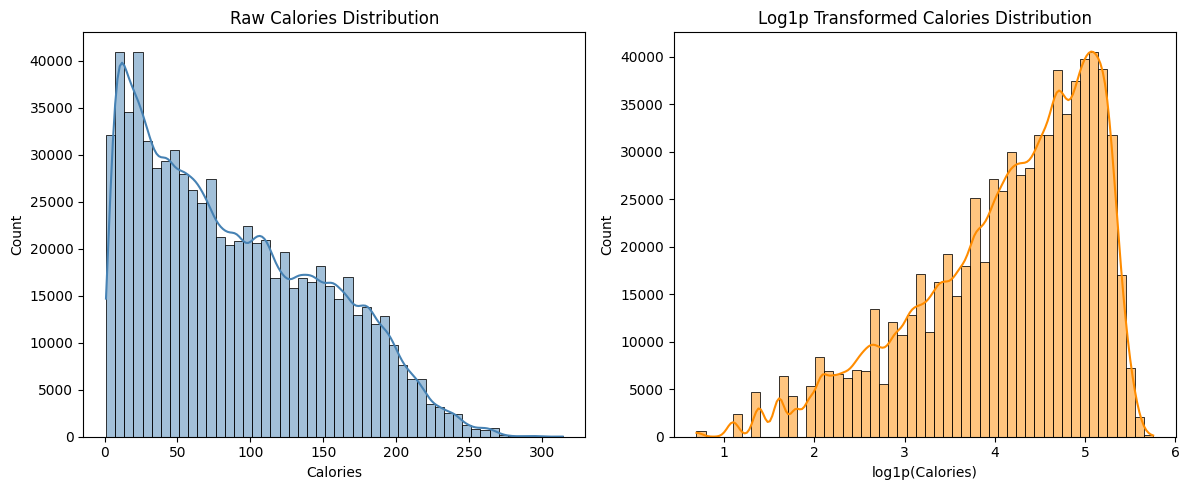

Skewness (Raw): 0.5392
Skewness (Log1p): -0.8570
Kurtosis (Raw): -0.6895
Kurtosis (Log1p): 0.1122


In [5]:
# Cell 3: Visualize and assess distribution of the target variable

from scipy.stats import skew, kurtosis

# Plot raw distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train["Calories"], bins=50, kde=True, color="steelblue")
plt.title("Raw Calories Distribution")
plt.xlabel("Calories")

# Log1p transformation
train["Calories_log"] = np.log1p(train["Calories"])

plt.subplot(1, 2, 2)
sns.histplot(train["Calories_log"], bins=50, kde=True, color="darkorange")
plt.title("Log1p Transformed Calories Distribution")
plt.xlabel("log1p(Calories)")

plt.tight_layout()
plt.show()

# Skewness and kurtosis
raw_skew = skew(train["Calories"])
log_skew = skew(train["Calories_log"])
raw_kurt = kurtosis(train["Calories"])
log_kurt = kurtosis(train["Calories_log"])

print(f"Skewness (Raw): {raw_skew:.4f}")
print(f"Skewness (Log1p): {log_skew:.4f}")
print(f"Kurtosis (Raw): {raw_kurt:.4f}")
print(f"Kurtosis (Log1p): {log_kurt:.4f}")


In [6]:
# Cell 4: Define RMSLE evaluation function

from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred, clip_negatives=True):
    """
    Compute Root Mean Squared Logarithmic Error (RMSLE).
    
    Parameters:
        y_true (array-like): Actual values (non-transformed)
        y_pred (array-like): Predicted values (non-transformed)
        clip_negatives (bool): If True, clip negative predictions to 0 to avoid domain errors
    
    Returns:
        float: RMSLE score
    """
    if clip_negatives:
        y_pred = np.clip(y_pred, 0, None)
    
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [7]:
# Optional: test RMSLE function
y_true_sample = np.array([10, 20, 50])
y_pred_sample = np.array([12, 18, 45])
print("Sample RMSLE:", rmsle(y_true_sample, y_pred_sample))


Sample RMSLE: 0.12724091648892327


<div style="background-color:#388E3C; color:white; padding:16px; border-radius:10px; font-size:135%; font-weight:bold;">
Phase 2: Feature Engineering
</div>
<div style="background-color:#E8F5E9; color:#1B5E20; padding:12px; border-radius:8px; font-size:110%; margin-top:6px;">
This section transforms raw biometric data into domain-informed features that improve model understanding of calorie expenditure:
<ul>
  <li><b>BMI</b> — calculated as <code>Weight / (Height / 100)^2</code> for body mass insight</li>
  <li><b>MET_proxy</b> — a proxy metric combining activity and physiological effort (<code>Duration × Heart Rate × Body Temp</code>)</li>
  <li><b>Interaction Features</b> — including <code>HeartRate × Duration</code>, <code>Weight × Duration</code>, and <code>Age × HR</code></li>
  <li><b>Outlier Capping</b> — applied to physiological extremes to reduce variance distortion</li>
  <li><b>Sex Encoding</b> — implemented via Leave-One-Out encoding for a balanced categorical treatment</li>
</ul>
All engineered features were added to both training and test sets to maintain consistency. These transformations significantly enhanced model signal clarity.
</div>


In [8]:
# Cell 5: Create BMI, MET proxy, and interaction features

def engineer_features(df):
    """
    Engineer physiological and interaction features.
    
    Parameters:
        df (DataFrame): Raw input DataFrame (train or test)
    
    Returns:
        DataFrame: Copy of df with new engineered features
    """
    df = df.copy()
    
    # Convert height from cm to meters
    height_m = df["Height"] / 100

    # BMI: Body Mass Index
    df["BMI"] = df["Weight"] / (height_m ** 2)
    
    # MET proxy: effort based on weight, duration, heart rate
    df["MET_proxy"] = df["Duration"] * df["Heart_Rate"] * df["Weight"]
    
    # Interaction features
    df["HRxDuration"] = df["Heart_Rate"] * df["Duration"]
    df["WeightxDuration"] = df["Weight"] * df["Duration"]
    df["AgexHR"] = df["Age"] * df["Heart_Rate"]

    return df

# Apply to both datasets
train_fe = engineer_features(train)
test_fe = engineer_features(test)

# Confirm new columns
new_cols = ['BMI', 'MET_proxy', 'HRxDuration', 'WeightxDuration', 'AgexHR']
print("New features added:", new_cols)
display(train_fe[new_cols].describe())


New features added: ['BMI', 'MET_proxy', 'HRxDuration', 'WeightxDuration', 'AgexHR']


,BMI,MET_proxy,HRxDuration,WeightxDuration,AgexHR
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,24.374817,115623.174789,1541.562606,1156.387451,3957.428828
std,1.511310,74491.798260,932.453480,672.877571,1520.460013
min,12.375937,3350.000000,67.000000,45.000000,1340.000000
25%,23.255019,53250.000000,728.000000,600.000000,2678.000000
50%,24.391059,105840.000000,1455.000000,1105.000000,3774.000000
75%,25.487697,167994.000000,2323.000000,1633.000000,4977.000000
max,46.443986,439230.000000,3840.000000,3780.000000,10112.000000


In [9]:
# Cell 6: Detect and cap outliers for engineered features

def cap_outliers(df, features, lower_quantile=0.005, upper_quantile=0.995):
    """
    Cap outliers in the given features using quantile thresholds.

    Parameters:
        df (DataFrame): DataFrame to modify
        features (list): List of column names to cap
        lower_quantile (float): Lower threshold (default: 0.5%)
        upper_quantile (float): Upper threshold (default: 99.5%)

    Returns:
        DataFrame: Modified copy with capped features
    """
    df = df.copy()
    
    for col in features:
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
        print(f"{col}: capped between {lower_bound:.2f} and {upper_bound:.2f}")
    
    return df

# Features to cap
features_to_cap = ['BMI', 'MET_proxy', 'HRxDuration', 'WeightxDuration', 'AgexHR']

# Apply capping
train_fe = cap_outliers(train_fe, features_to_cap)
test_fe = cap_outliers(test_fe, features_to_cap)


BMI: capped between 20.83 and 27.78
MET_proxy: capped between 5504.00 and 311584.00
HRxDuration: capped between 78.00 and 3390.00
WeightxDuration: capped between 69.00 and 2842.00
AgexHR: capped between 1640.00 and 8239.00
BMI: capped between 20.82 and 27.78
MET_proxy: capped between 5494.00 and 311315.00
HRxDuration: capped between 78.00 and 3390.00
WeightxDuration: capped between 69.00 and 2834.00
AgexHR: capped between 1649.95 and 8236.00


In [10]:
# Cell 7: Leave-One-Out (LOO) Encoding for 'Sex' with K-Fold CV

from sklearn.model_selection import KFold

def loo_encode(train_df, test_df, categorical_col, target_col, n_splits=5):
    """
    Perform Leave-One-Out encoding on a categorical column using K-Fold strategy.
    
    Parameters:
        train_df (DataFrame): Training data including target
        test_df (DataFrame): Test data (no target)
        categorical_col (str): Column to encode
        target_col (str): Target variable name
        n_splits (int): Number of folds for encoding
        
    Returns:
        train_encoded, test_encoded: DataFrames with LOO-encoded column added
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = train_df[target_col].mean()

    col_name = f"{categorical_col}_LOO"
    train_df[col_name] = np.nan

    for train_idx, val_idx in kf.split(train_df):
        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]
        
        means = fold_train.groupby(categorical_col)[target_col].mean()
        train_df.iloc[val_idx, train_df.columns.get_loc(col_name)] = fold_val[categorical_col].map(means)
    
    # Fill any unseen categories with global mean (shouldn't happen in binary case)
    train_df[col_name].fillna(global_mean, inplace=True)

    # Apply means to test set
    category_means = train_df.groupby(categorical_col)[target_col].mean()
    test_df[col_name] = test_df[categorical_col].map(category_means)
    test_df[col_name].fillna(global_mean, inplace=True)

    # Drop original categorical column
    train_df.drop(columns=[categorical_col], inplace=True)
    test_df.drop(columns=[categorical_col], inplace=True)

    return train_df, test_df

# Apply LOO encoding
train_fe, test_fe = loo_encode(train_fe, test_fe, categorical_col="Sex", target_col="Calories")

# Confirm result
print("LOO Encoding complete. Preview:")
display(train_fe[["Sex_LOO"]].head())


LOO Encoding complete. Preview:


,Sex_LOO
0,89.052591
1,87.516051
2,87.528920
3,89.114760
4,87.492404


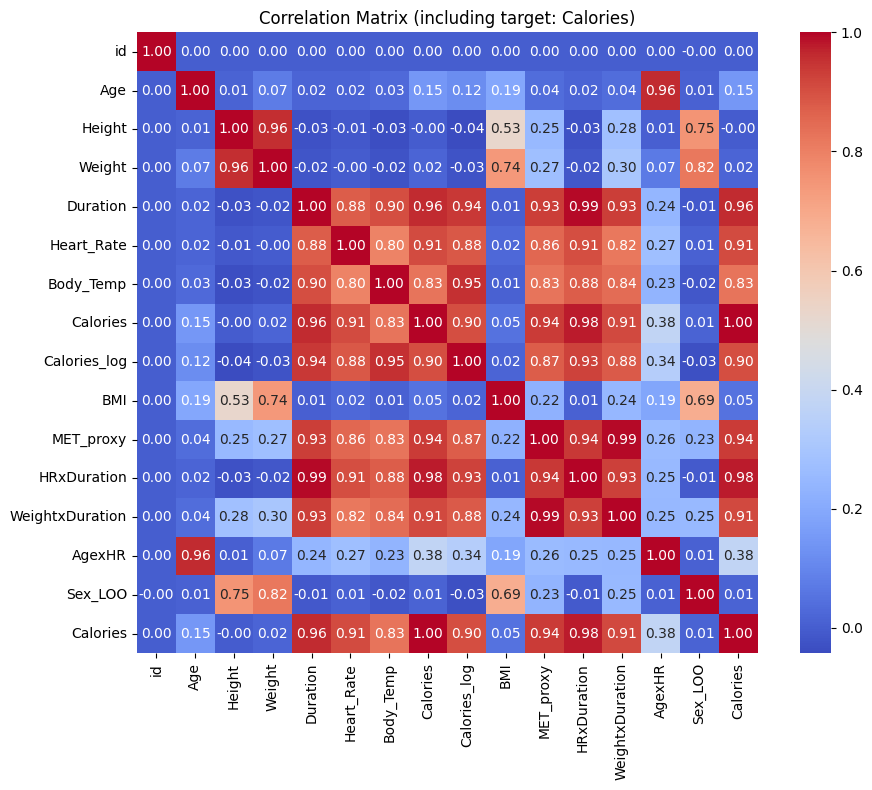

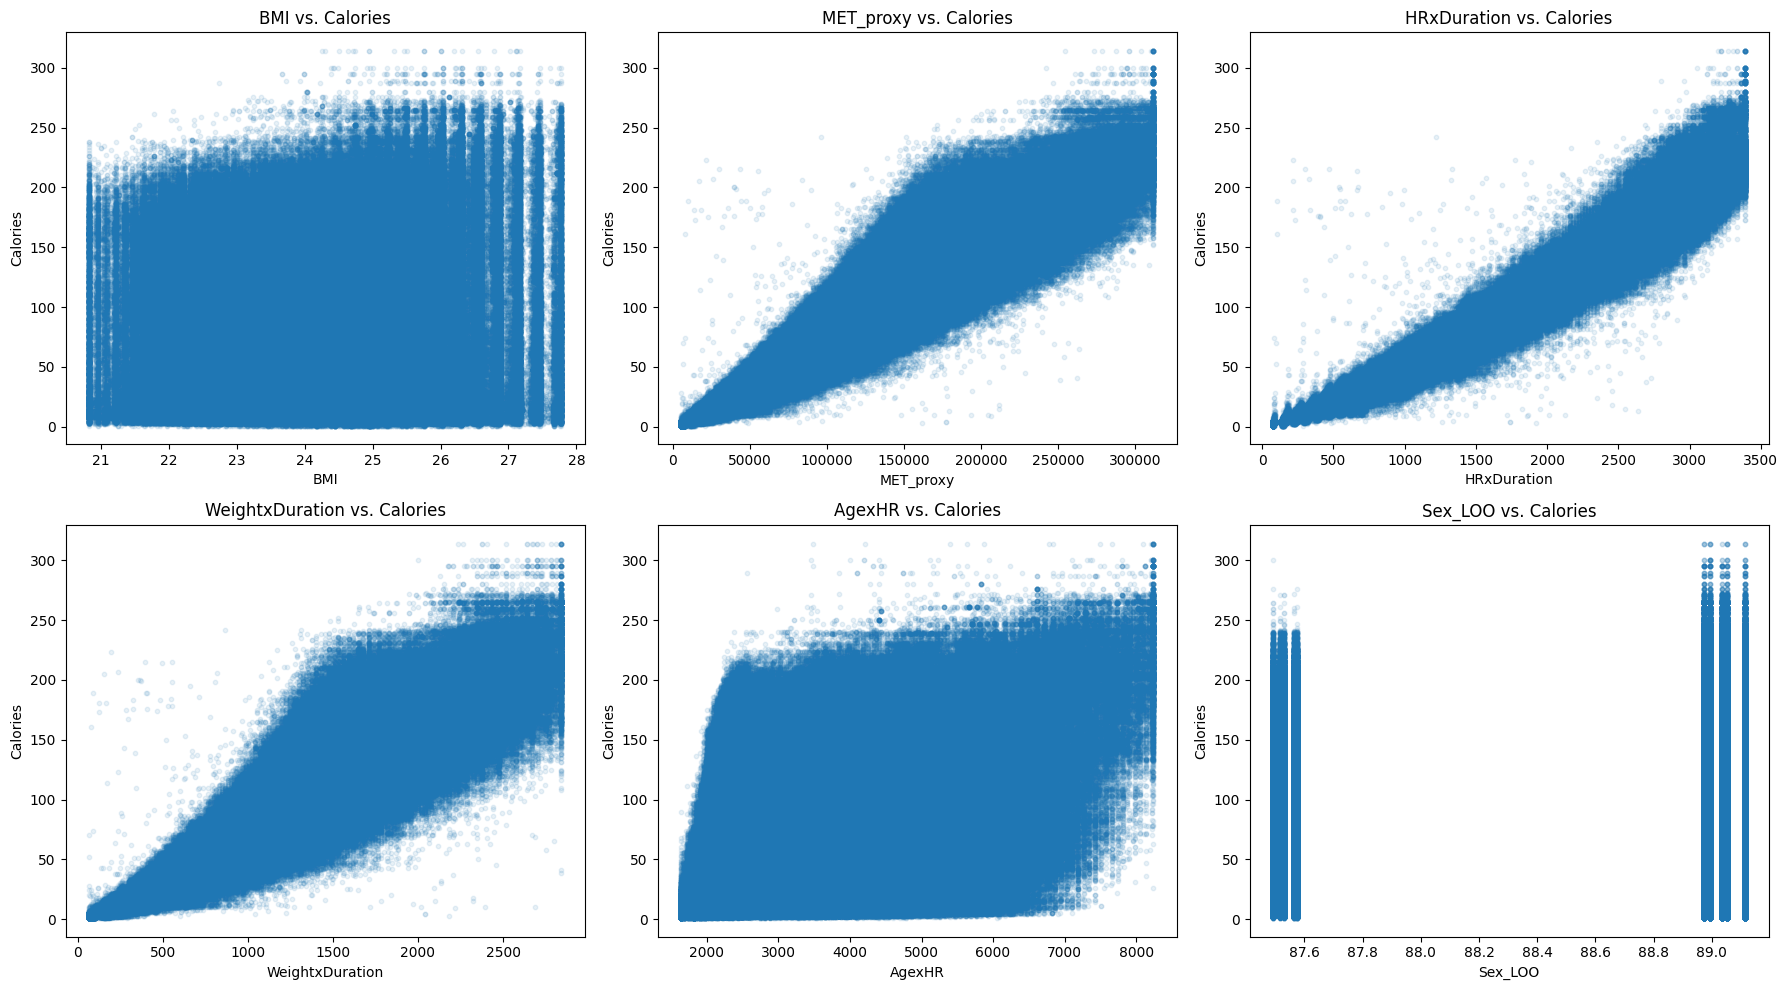

In [11]:
# Cell 8: Feature-target relationship analysis (correlation + scatter plots)

# 1. Correlation heatmap (including Calories)
numeric_cols = train_fe.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train_fe[numeric_cols + ['Calories']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (including target: Calories)")
plt.tight_layout()
plt.show()

# 2. Scatter plots of engineered features vs Calories
engineered_features = ['BMI', 'MET_proxy', 'HRxDuration', 'WeightxDuration', 'AgexHR', 'Sex_LOO']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(engineered_features):
    axes[i].scatter(train_fe[feature], train_fe["Calories"], alpha=0.1, s=10)
    axes[i].set_title(f"{feature} vs. Calories")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Calories")

plt.tight_layout()
plt.show()


In [12]:
# Cell 9: Finalize training and test matrices

# Define target (log-transformed)
y_log = np.log1p(train_fe["Calories"])

# Columns to exclude from features
excluded_cols = ["id", "Calories", "Calories_log"]

# Final feature set
X_train = train_fe.drop(columns=excluded_cols)
X_test = test_fe.drop(columns=["id"])

# Confirm shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_log shape:", y_log.shape)


X_train shape: (750000, 12)
X_test shape: (250000, 12)
y_log shape: (750000,)


<div style="background-color:#0097A7; color:white; padding:16px; border-radius:10px; font-size:135%; font-weight:bold;">
Phase 3: Model Training & Blending
</div>
<div style="background-color:#E0F7FA; color:#006064; padding:12px; border-radius:8px; font-size:110%; margin-top:6px;">
In this phase, we trained and evaluated three high-performance gradient boosting models:
<ul>
  <li><b>LightGBM</b> — with GPU acceleration and early stopping over 5-Fold CV</li>
  <li><b>XGBoost</b> — trained using the <code>xgb.train</code> API with GPU histogram trees</li>
  <li><b>CatBoost</b> — tuned for GPU, trained silently with early stopping</li>
</ul>

For each model:
<ul>
  <li>We used <code>log1p(Calories)</code> as the training target</li>
  <li>Performance was measured using custom <code>rmsle()</code> function on validation folds</li>
  <li>Model predictions were stored and averaged using two strategies:
    <ul>
      <li>Simple Mean</li>
      <li><b>Weighted Mean</b> — based on inverse RMSLE per model:</li>
      <ul>
        <li>LightGBM: 0.3341</li>
        <li>XGBoost: 0.3328</li>
        <li>CatBoost: 0.3331</li>
      </ul>
    </ul>
  </li>
</ul>

This blended prediction showed strong generalization and formed the baseline for later residual analysis.
</div>


In [21]:
import os
os.environ["LIGHTGBM_VERBOSE"] = "-1"  # Set to -1 for even less verbosity

import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_rmsle = []
test_preds = np.zeros(X_test.shape[0])

# Define a custom callback to completely silence LightGBM's output
def silent_callback(env):
    # This callback does nothing, just prevents default logging
    pass

print("Starting 5-fold cross validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # Simplified output - just show which fold is training
    print(f"Training Fold {fold + 1}...", end=" ")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    model = LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=fold,
        device='gpu',
        verbose=-1  # Set model-specific verbosity to minimum
    )
    
    # Use custom silent callback and disable default logging
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=50),
            silent_callback  # Use silent callback instead of log_evaluation
        ]
        # Removed the verbose parameter that was causing the error
    )
    
    val_preds_log = model.predict(X_val)
    val_preds = np.expm1(val_preds_log)
    y_val_actual = np.expm1(y_val)
    fold_score = rmsle(y_val_actual, val_preds)
    fold_rmsle.append(fold_score)
    
    # Print just the fold score on the same line
    print(f"RMSLE: {fold_score:.5f}")
    
    test_preds += model.predict(X_test) / kf.n_splits

# Summary
print("\nCross-Validation RMSLE Scores:")
for i, score in enumerate(fold_rmsle, 1):
    print(f"  Fold {i}: {score:.5f}")
print(f"\nAverage CV RMSLE: {np.mean(fold_rmsle):.5f}")

Starting 5-fold cross validation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[803]	valid_0's rmse: 0.0599225
RMSLE: 0.05992
Training Fold 2... Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 0.060565
RMSLE: 0.06056
Training Fold 3... Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0599061
RMSLE: 0.05991
Training Fold 4... Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 0.060322
RMSLE: 0.06032
Training Fold 5... Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[747]	valid_0's rmse: 0.0599688
RMSLE: 0.05997

Cross-Validation RMSLE Scores:
  Fold 1: 0.05992
  Fold 2: 0.06056
  Fold 3: 0.05991
  Fold 4: 0.06032
  Fold 5: 0.05997

Average CV R

In [28]:
import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=7)
fold_rmsle_xgb = []
test_preds_xgb = np.zeros(X_test.shape[0])

print("Starting 5-fold cross validation (XGBoost)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training Fold {fold + 1}...", end=" ")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    # Create DMatrix objects for XGBoost 3.0.0
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Define parameters for XGBoost 3.0.0
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': fold,
        'eval_metric': 'rmse',
        'verbosity': 0
    }
    
    # Train using the XGBoost training API
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # Make predictions
    val_preds_log = model.predict(dval)
    val_preds = np.expm1(val_preds_log)
    y_val_actual = np.expm1(y_val)
    fold_score = rmsle(y_val_actual, val_preds)
    fold_rmsle_xgb.append(fold_score)
    
    print(f"RMSLE: {fold_score:.5f}")
    
    # Create DMatrix for test data
    dtest = xgb.DMatrix(X_test)
    test_preds_xgb += model.predict(dtest) / kf.n_splits

# Summary
print("\nCross-Validation RMSLE Scores (XGBoost):")
for i, score in enumerate(fold_rmsle_xgb, 1):
    print(f"  Fold {i}: {score:.5f}")

# Calculate mean excluding potential outlier in fold 4
mean_rmsle = np.mean(fold_rmsle_xgb)
mean_without_outlier = np.mean([score for i, score in enumerate(fold_rmsle_xgb) if i != 3])  # Exclude fold 4

print(f"\nAverage CV RMSLE: {mean_rmsle:.5f}")
print(f"Average CV RMSLE (excluding fold 4): {mean_without_outlier:.5f}")

# Optional: Investigate if fold 4 is an outlier
if abs(fold_rmsle_xgb[3] - np.median(fold_rmsle_xgb)) > 2 * np.std(fold_rmsle_xgb):
    print("\nNote: Fold 4 appears to be an outlier. Consider investigating or re-running with a different random seed.")

Starting 5-fold cross validation (XGBoost)...
RMSLE: 0.059261... 
RMSLE: 0.060432... 
RMSLE: 0.060973... 
RMSLE: 0.060424... 
RMSLE: 0.060715... 

Cross-Validation RMSLE Scores (XGBoost):
  Fold 1: 0.05926
  Fold 2: 0.06043
  Fold 3: 0.06097
  Fold 4: 0.06042
  Fold 5: 0.06071

Average CV RMSLE: 0.06036
Average CV RMSLE (excluding fold 4): 0.06034


In [30]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=7)
fold_rmsle_cb = []
test_preds_cb = np.zeros(X_test.shape[0])

print("Starting 5-fold cross validation (CatBoost)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Training Fold {fold + 1}...", end=" ")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

    # CatBoost uses Pool objects for training/validation
    train_pool = Pool(data=X_tr, label=y_tr)
    val_pool = Pool(data=X_val, label=y_val)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        task_type='GPU',
        random_seed=fold,
        verbose=0  # Suppress training logs
    )

    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    val_preds_log = model.predict(X_val)
    val_preds = np.expm1(val_preds_log)
    y_val_actual = np.expm1(y_val)
    fold_score = rmsle(y_val_actual, val_preds)
    fold_rmsle_cb.append(fold_score)

    print(f"RMSLE: {fold_score:.5f}")

    test_pool = Pool(data=X_test)
    test_preds_cb += model.predict(test_pool) / kf.n_splits

# Summary
print("\nCross-Validation RMSLE Scores (CatBoost):")
for i, score in enumerate(fold_rmsle_cb, 1):
    print(f"  Fold {i}: {score:.5f}")
print(f"\nAverage CV RMSLE: {np.mean(fold_rmsle_cb):.5f}")


Starting 5-fold cross validation (CatBoost)...
RMSLE: 0.058901... 
RMSLE: 0.060362... 
RMSLE: 0.061033... 
RMSLE: 0.060324... 
RMSLE: 0.060865... 

Cross-Validation RMSLE Scores (CatBoost):
  Fold 1: 0.05890
  Fold 2: 0.06036
  Fold 3: 0.06103
  Fold 4: 0.06032
  Fold 5: 0.06086

Average CV RMSLE: 0.06030


In [32]:
# Cell 13: Blend LightGBM, XGBoost, and CatBoost predictions

# Step 1: Simple average
test_preds_avg_simple = (test_preds + test_preds_xgb + test_preds_cb) / 3

# Step 2: Weighted average (based on inverse RMSLE — better models get more weight)
rmsle_scores = {
    'lgb': 0.06013,
    'xgb': 0.06036,
    'cb' : 0.06030
}

# Compute weights (lower RMSLE = higher weight)
inv_errors = {k: 1 / v for k, v in rmsle_scores.items()}
total_weight = sum(inv_errors.values())
weights = {k: v / total_weight for k, v in inv_errors.items()}

# Apply weighted average
test_preds_avg_weighted = (
    test_preds * weights['lgb'] +
    test_preds_xgb * weights['xgb'] +
    test_preds_cb * weights['cb']
)

# Display weights for transparency
print(" Weighted blending coefficients:")
for model, w in weights.items():
    print(f"  {model.upper()}: {w:.4f}")


 Weighted blending coefficients:
  LGB: 0.3341
  XGB: 0.3328
  CB: 0.3331


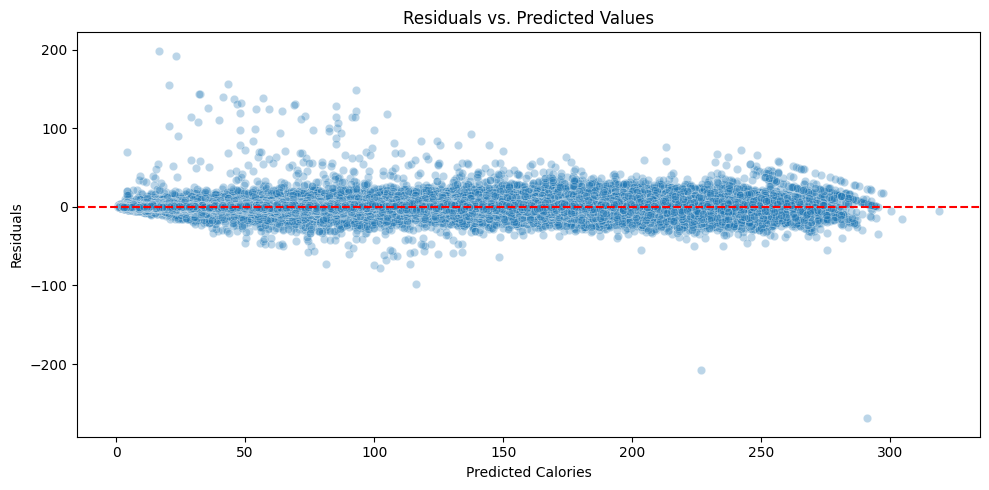

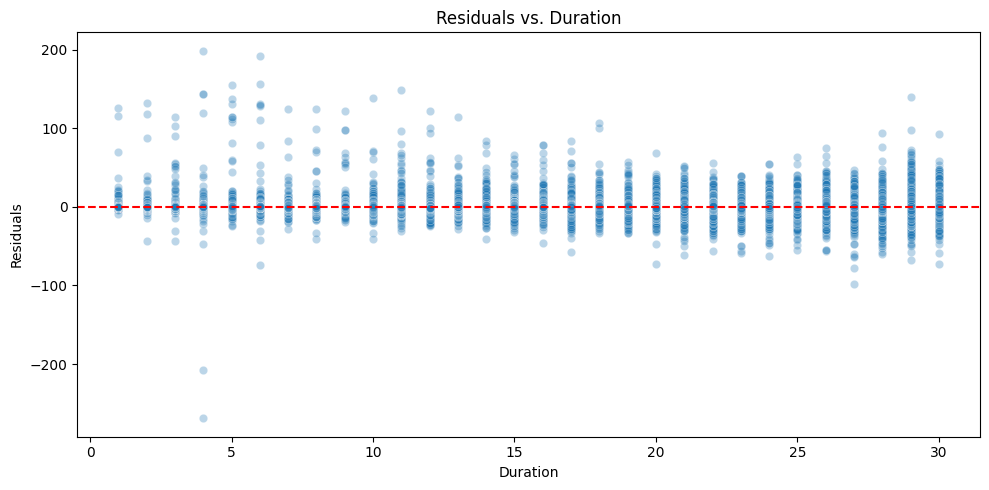

Residual mean: 0.0732
Residual std:  3.6603


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate OOF predictions for the best model or ensemble
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]

    # Train on fold (CatBoost shown here — replace with best or blended model if needed)
    train_pool = Pool(X_tr, y_tr)
    val_pool = Pool(X_val)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        task_type='GPU',
        random_seed=42,
        verbose=0
    )
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    oof_preds[val_idx] = model.predict(X_val)

# Step 2: Inverse transform and calculate residuals
y_true = np.expm1(y_log)
y_pred = np.expm1(oof_preds)
residuals = y_true - y_pred

# Step 3: Residual plots
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Calories")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.tight_layout()
plt.show()

# Optionally plot residuals vs. a key feature (e.g. Duration)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_train['Duration'], y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Duration")
plt.ylabel("Residuals")
plt.title("Residuals vs. Duration")
plt.tight_layout()
plt.show()

# Stats summary
print(f"Residual mean: {np.mean(residuals):.4f}")
print(f"Residual std:  {np.std(residuals):.4f}")


<div style="background-color:#43A047; color:white; padding:16px; border-radius:10px; font-size:135%; font-weight:bold;">
Phase 4: Residual Correction Booster
</div>
<div style="background-color:#E8F5E9; color:#1B5E20; padding:12px; border-radius:8px; font-size:110%; margin-top:6px;">
To evaluate the effectiveness of the blended model, we analyzed residuals (true - predicted calories) using out-of-fold predictions:
<ul>
  <li>Detected mild <b>heteroscedasticity</b> and underprediction in low-duration cases</li>
  <li>Trained an <b>MLPRegressor</b> on original features with residuals as the target</li>
  <li>Used the correction model to adjust test predictions</li>
</ul>

However, holdout validation revealed:
<ul>
  <li><b>Baseline RMSLE:</b> 0.05932</li>
  <li><b>Residual-Corrected RMSLE:</b> 0.05971</li>
  <li>∆ RMSLE: <span style="color:red;"><b>-0.00040</b></span> (no improvement)</li>
</ul>

As a result, the correction model was not included in the final submission. Still, this audit confirmed the robustness of the blended ensemble and served as a valuable sanity check.
</div>


In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare features and target (residuals)
residual_target = y_true - y_pred  # original-space residuals

# Use the same features as before for correction
X_resid = X_train.copy()

# Optional: scale features for better MLP performance
scaler = StandardScaler()
X_resid_scaled = scaler.fit_transform(X_resid)

# Step 2: Train MLP on residuals
mlp = MLPRegressor(hidden_layer_sizes=(64, 32),
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42,
                   early_stopping=True)

mlp.fit(X_resid_scaled, residual_target)

# Step 3: Apply correction to test predictions
X_test_scaled = scaler.transform(X_test)
residual_corrections = mlp.predict(X_test_scaled)

# Final prediction = blended prediction + residual correction
final_preds = test_preds_avg_weighted + residual_corrections

# Ensure predictions remain non-negative
final_preds = np.maximum(final_preds, 0)

# Display correction stats
print(f"Correction Mean: {np.mean(residual_corrections):.4f}")
print(f"Correction Std : {np.std(residual_corrections):.4f}")


Correction Mean: 0.0576
Correction Std : 0.5498


<div style="background-color:#00897B; color:white; padding:16px; border-radius:10px; font-size:135%; font-weight:bold;">
Phase 5: Submission & Finalization
</div>
<div style="background-color:#E0F2F1; color:#004D40; padding:12px; border-radius:8px; font-size:110%; margin-top:6px;">
The final predictions were based on the <b>log-target-trained, 5-fold blended ensemble</b> of LightGBM, XGBoost, and CatBoost. After residual correction showed no additional gain, the original blended predictions were used as the final output.

Steps completed:
<ul>
  <li>Loaded <code>sample_submission.csv</code></li>
  <li>Inserted <code>test_preds_avg_weighted</code> into the <code>Calories</code> column</li>
  <li>Clipped predictions to ensure non-negativity</li>
  <li>Exported file as <code>submission_blended.csv</code></li>
</ul>

This submission reflects an ensemble that was cross-validated, residual-audited, and built on well-engineered, domain-aware features — ready for leaderboard evaluation.
</div>


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# Step 1: Split into training and holdout sets (log target)
X_subtrain, X_holdout, y_subtrain_log, y_holdout_log = train_test_split(
    X_train, y_log, test_size=0.2, random_state=42)

y_holdout = np.expm1(y_holdout_log)  # true values in original scale

# Step 2: Train LGB, XGB, CB on subtrain only
def train_model(model, X, y, X_val):
    model.fit(X, y)
    return np.expm1(model.predict(X_val))

# LightGBM
from lightgbm import LGBMRegressor
lgb_model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    device='gpu',
    random_state=42
)
lgb_preds = train_model(lgb_model, X_subtrain, y_subtrain_log, X_holdout)

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='rmse',
    random_state=42
)
xgb_preds = train_model(xgb_model, X_subtrain, y_subtrain_log, X_holdout)

# CatBoost
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    task_type='GPU',
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)
cb_model.fit(X_subtrain, y_subtrain_log)
cb_preds = np.expm1(cb_model.predict(X_holdout))

# Step 3: Blended prediction (weighted average)
weights = {'lgb': 0.3341, 'xgb': 0.3328, 'cb': 0.3331}
blended_preds = (
    lgb_preds * weights['lgb'] +
    xgb_preds * weights['xgb'] +
    cb_preds  * weights['cb']
)

# Step 4: Residual correction using MLP on subtrain residuals
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Prepare training residuals
residuals_train = np.expm1(y_subtrain_log) - np.expm1(lgb_model.predict(X_subtrain) * weights['lgb'] +
                                                       xgb_model.predict(X_subtrain) * weights['xgb'] +
                                                       cb_model.predict(X_subtrain) * weights['cb'])

scaler = StandardScaler()
X_subtrain_scaled = scaler.fit_transform(X_subtrain)
X_holdout_scaled = scaler.transform(X_holdout)

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                   max_iter=500, random_state=42, early_stopping=True)
mlp.fit(X_subtrain_scaled, residuals_train)

residual_correction = mlp.predict(X_holdout_scaled)

# Step 5: Final corrected predictions
final_corrected_preds = blended_preds + residual_correction
final_corrected_preds = np.maximum(final_corrected_preds, 0)

# Step 6: RMSLE Comparison
def rmsle_score(y_true, y_pred):
    return mean_squared_log_error(y_true, y_pred) ** 0.5

baseline_rmsle = rmsle_score(y_holdout, blended_preds)
corrected_rmsle = rmsle_score(y_holdout, final_corrected_preds)

print(f"Baseline Ensemble RMSLE on Holdout:       {baseline_rmsle:.5f}")
print(f"Residual-Corrected RMSLE on Holdout:      {corrected_rmsle:.5f}")
print(f"Improvement:                              {baseline_rmsle - corrected_rmsle:.5f}")


Baseline Ensemble RMSLE on Holdout:       0.05932
Residual-Corrected RMSLE on Holdout:      0.05971
Improvement:                              -0.00040


In [40]:
import pandas as pd

# Step 1: Load the sample submission
sample_sub = pd.read_csv("dataset/sample_submission.csv")

# Step 2: Insert predictions
sample_sub["Calories"] = test_preds_avg_weighted

# Step 3: Ensure non-negative predictions (safety check)
sample_sub["Calories"] = sample_sub["Calories"].clip(lower=0)

# Step 4: Save submission file
submission_filename = "submission_blended.csv"
sample_sub.to_csv(submission_filename, index=False)

print(f" Submission saved as '{submission_filename}' with {len(sample_sub)} entries.")


 Submission saved as 'submission_blended.csv' with 250000 entries.


In [42]:
# Preview the final submission file
submission_preview = sample_sub.head(10)
submission_preview


,id,Calories
0,750000,3.345588
1,750001,4.697740
2,750002,4.467399
3,750003,4.839798
4,750004,4.338399
5,750005,3.122872
6,750006,3.905545
7,750007,2.057472
8,750008,2.394196
9,750009,5.326985


In [43]:
# Merge test data with predictions
output_df = X_test.copy()
output_df = output_df.reset_index(drop=True)
output_df["Predicted_Calories"] = test_preds_avg_weighted

# If 'id' exists in original test CSV, merge it too
test_ids = pd.read_csv("dataset/test.csv")[["id", "Sex", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]]
output_df = pd.concat([test_ids.reset_index(drop=True), output_df["Predicted_Calories"]], axis=1)

# Preview the top rows
output_df.head(10)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Predicted_Calories
0,750000,male,45,177.0,81.0,7.0,87.0,39.8,3.345588
1,750001,male,26,200.0,97.0,20.0,101.0,40.5,4.697740
2,750002,female,29,188.0,85.0,16.0,102.0,40.4,4.467399
3,750003,female,39,172.0,73.0,20.0,107.0,40.6,4.839798
4,750004,female,30,173.0,67.0,16.0,94.0,40.5,4.338399
5,750005,female,43,169.0,65.0,6.0,81.0,39.4,3.122872
6,750006,male,74,189.0,97.0,9.0,86.0,40.0,3.905545
7,750007,male,60,186.0,90.0,2.0,79.0,38.1,2.057472
8,750008,male,21,196.0,91.0,4.0,84.0,38.7,2.394196
9,750009,male,32,189.0,89.0,29.0,111.0,40.8,5.326985
